# Case 2 - Clustering

### Import Modules

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

### Load Data

In [2]:
data_path = '../../case_2/data/HR_data.csv'

data_pd = pd.read_csv(data_path)

### Extract numerical features

In [3]:
identifier_columns = ['Unnamed: 0','Round', 'Phase', 'Individual','Puzzler', 'Cohort']
emotion_columns = ['inspired', 'attentive', 'determined','active','alert','Frustrated', 'upset', 'hostile', 'ashamed', 'nervous', 'afraid']
numeric_columns = [col for col in data_pd.columns if col not in identifier_columns + emotion_columns]

### Preproccessing Data

In [4]:
def preprocess_data(df, features_to_use):
    """
    Preprocess the data for clustering
    """
    X = df[features_to_use].copy()
    X = X.fillna(X.mean())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

In [6]:
X_scaled, scaler = preprocess_data(data_pd, numeric_columns)


## Clustering Methods

### Hierarchical Clustering

In [7]:
def apply_hierarchical_clustering(X, n_clusters=3):
    """
    Apply hierarchical clustering and visualize dendrogram
    """
    # Compute linkage matrix
    Z = linkage(X, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(Z)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.axhline(y=15, c='k', linestyle='--', label='Cut-off for {} clusters'.format(n_clusters))
    plt.legend()
    
    # Apply clustering with the chosen number of clusters
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clustering.fit_predict(X)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X, labels)
    print(f"Silhouette Score for Hierarchical Clustering: {sil_score:.3f}")
    
    return labels

### K-means Clustering

In [8]:
def apply_kmeans_clustering(X, max_clusters=10):
    """
    Apply K-means clustering and determine optimal k using elbow method
    """
    # Elbow method to find optimal k
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_clusters + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(X, labels)
        silhouette_scores.append(sil_score)
    
    # Plot elbow method results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'o-')
    plt.title('Elbow Method for K-means')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'o-')
    plt.title('Silhouette Scores for K-means')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
    plt.tight_layout()
    
    # Choose optimal k based on silhouette scores
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
    
    # Apply K-means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    return labels, kmeans.cluster_centers_, optimal_k

### GMM Clustering

In [9]:
def apply_gmm_clustering(X, max_components=10):
    """
    Apply Gaussian Mixture Model clustering
    """
    # Find optimal number of components using BIC
    bic_scores = []
    n_components_range = range(1, max_components + 1)
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))
    
    # Plot BIC scores
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, bic_scores, 'o-')
    plt.title('BIC Scores for different numbers of GMM components')
    plt.xlabel('Number of components')
    plt.ylabel('BIC Score')
    
    # Choose optimal number of components based on BIC
    optimal_components = n_components_range[bic_scores.index(min(bic_scores))]
    print(f"Optimal number of GMM components based on BIC: {optimal_components}")
    
    # Apply GMM with optimal number of components
    gmm = GaussianMixture(n_components=optimal_components, random_state=42)
    labels = gmm.fit_predict(X)
    
    return labels, gmm.means_, optimal_components

### DBScan Clustering

In [10]:
def apply_dbscan(X):
    """
    Apply DBSCAN clustering to identify outliers and natural clusters
    """
    # Estimate epsilon using nearest neighbors
    from sklearn.neighbors import NearestNeighbors
    
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:, 1])
    
    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Points sorted by distance')
    plt.ylabel('Distance to 2nd nearest neighbor')
    
    # Choose epsilon from the elbow in the k-distance graph (for demonstration, we'll use a heuristic)
    epsilon = np.percentile(distances, 90) * 0.5
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=3)
    labels = dbscan.fit_predict(X)
    
    # Count number of clusters and noise points
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    
    return labels


### Plotting functions

In [11]:
def visualize_clusters_2d(X, labels, centers=None, method_name=""):
    """
    Visualize clusters in 2D using PCA or UMAP
    """
    # Apply dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Create a figure with two subplots
    plt.figure(figsize=(18, 8))
    
    # PCA plot
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
    if centers is not None:
        centers_pca = pca.transform(centers)
        plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=100, marker='X')
    plt.title(f'PCA Visualization of {method_name} Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster')
    
    plt.tight_layout()

In [12]:
def analyze_clusters(df, labels, feature_cols):
    """
    Analyze and interpret the resulting clusters
    """
    # Add cluster labels to the original dataframe
    df['cluster'] = labels
    
    # Calculate cluster statistics
    cluster_stats = df.groupby('cluster')[feature_cols].mean()
    
    # Plot heatmap of cluster characteristics
    plt.figure(figsize=(15, 10))
    sns.heatmap(cluster_stats, cmap='coolwarm', center=0, annot=True, fmt='.2f')
    plt.title('Cluster Characteristics')
    plt.tight_layout()
    
    # Create radar plots for each cluster
    n_clusters = len(cluster_stats)
    n_features = len(feature_cols)
    
    # Normalize the features for radar plot
    scaler = StandardScaler()
    cluster_stats_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_stats),
        index=cluster_stats.index,
        columns=cluster_stats.columns
    )
    
    # Create radar plot
    fig = plt.figure(figsize=(15, 10))
    theta = np.linspace(0, 2*np.pi, n_features, endpoint=False)
    theta = np.concatenate((theta, [theta[0]]))  # Close the loop
    
    for i in range(n_clusters):
        values = cluster_stats_scaled.iloc[i].values
        values = np.concatenate((values, [values[0]]))  # Close the loop
        
        ax = fig.add_subplot(2, (n_clusters+1)//2, i+1, polar=True)
        ax.plot(theta, values)
        ax.fill(theta, values, alpha=0.25)
        ax.set_xticks(theta[:-1])
        ax.set_xticklabels(feature_cols, size=8)
        ax.set_title(f'Cluster {i}')
    
    plt.tight_layout()
    
    return cluster_stats

## Results

### Hierarchical Clustering

Silhouette Score for Hierarchical Clustering: 0.161


,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,HR_TD_Slope_max,...,EDA_TD_T_AUC,EDA_TD_T_Kurtosis,EDA_TD_T_Skew,EDA_TD_T_Slope_min,EDA_TD_T_Slope_max,EDA_TD_T_Slope_mean,EDA_TD_T_Slope,EDA_TD_P_Peaks,EDA_TD_P_RT,EDA_TD_P_ReT
cluster,,,,,,,,,,,,,,,,,,,,,
0,76.608038,75.912418,4.696084,69.364945,86.492088,23705.500110,-0.085531,0.255884,-0.416410,0.399471,...,9779.182392,0.911132,-0.353020,-0.060666,0.049662,0.000021,0.000163,24.582418,2.007988,1.953446
1,79.078713,77.766755,7.319329,68.289183,94.713846,24503.419928,-0.000824,0.440457,-0.629989,0.569824,...,2000.736835,0.269452,0.046238,-0.008554,0.008662,-0.000190,-0.000173,21.865385,1.993034,2.086977
2,83.683697,83.213846,7.114485,72.499231,97.960769,25388.186538,-0.699980,0.184971,-0.636154,0.530000,...,10990.739485,-0.081863,-0.232632,-0.188413,0.147738,-0.002165,-0.001831,42.538462,2.014128,1.274131


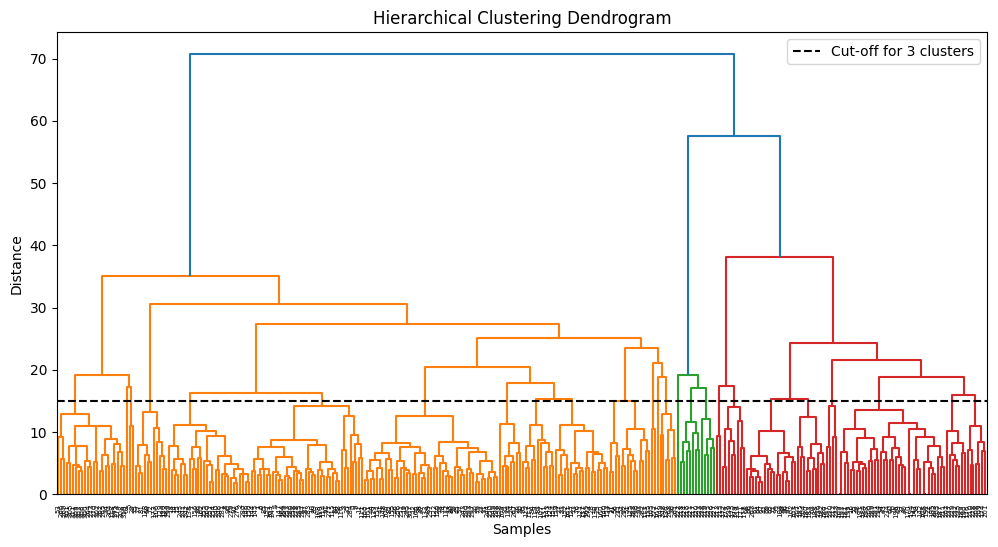

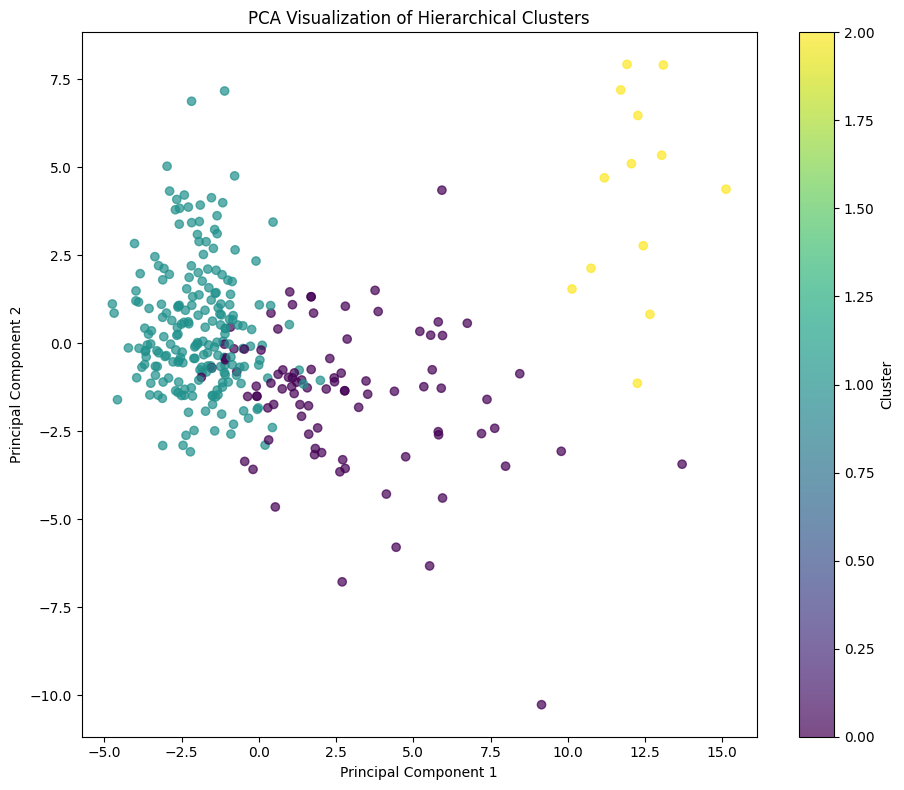

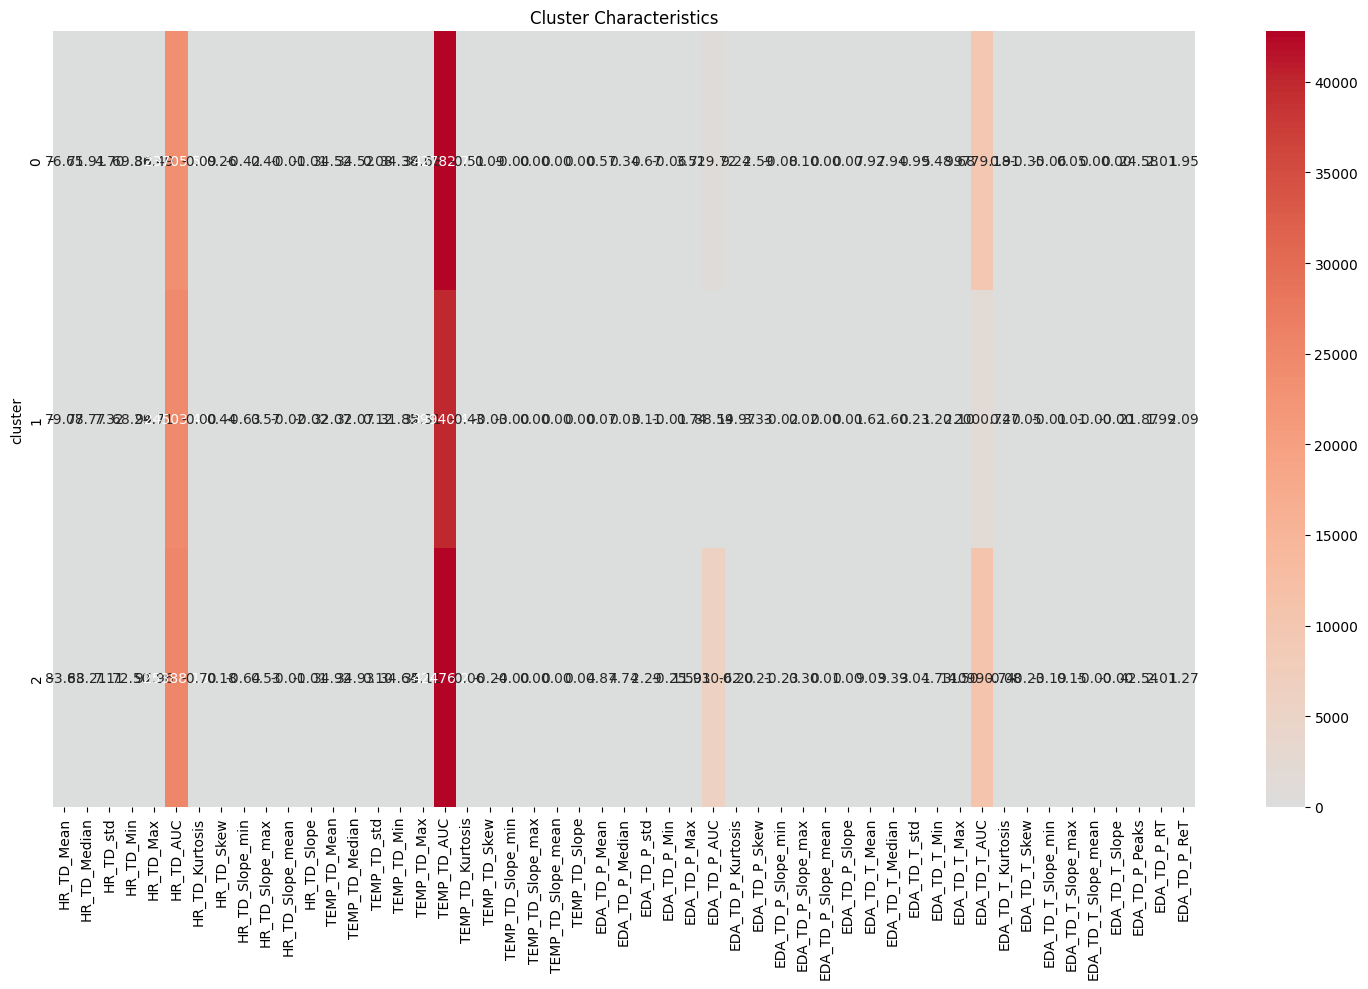

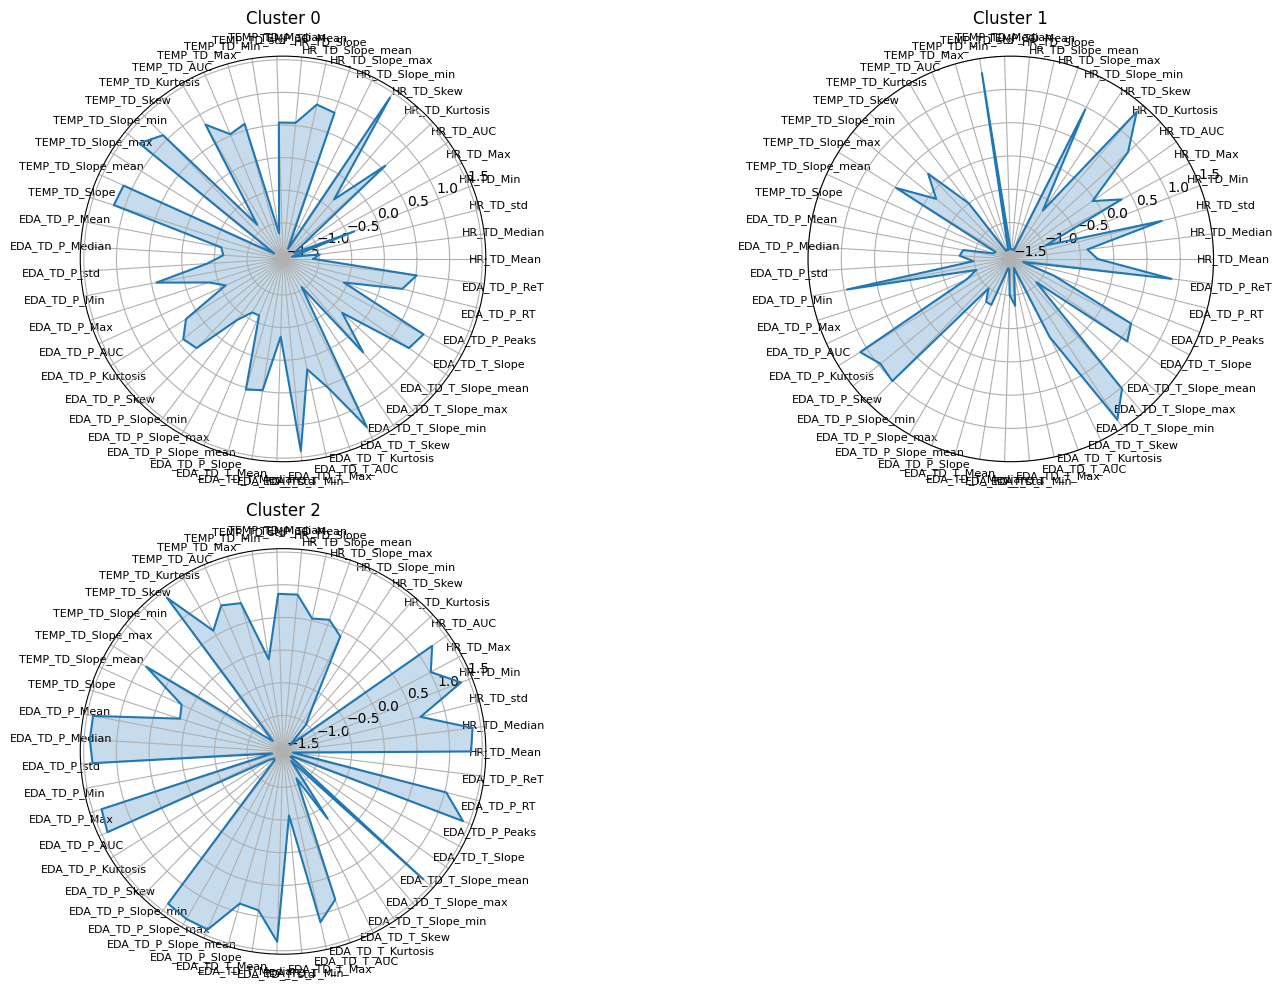

In [13]:
hierarchical_labels = apply_hierarchical_clustering(X_scaled, n_clusters=3)
visualize_clusters_2d(X_scaled, hierarchical_labels, method_name="Hierarchical")
analyze_clusters(data_pd, hierarchical_labels, numeric_columns)

### K-means Clustering

Optimal number of clusters based on silhouette score: 2


,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,HR_TD_Slope_max,...,EDA_TD_T_AUC,EDA_TD_T_Kurtosis,EDA_TD_T_Skew,EDA_TD_T_Slope_min,EDA_TD_T_Slope_max,EDA_TD_T_Slope_mean,EDA_TD_T_Slope,EDA_TD_P_Peaks,EDA_TD_P_RT,EDA_TD_P_ReT
cluster,,,,,,,,,,,,,,,,,,,,,
0,78.605357,77.40671,6.661103,68.727426,92.812206,24351.333290,-0.008990,0.405856,-0.574596,0.525416,...,2972.206747,0.366197,-0.005546,-0.015809,0.014538,-0.000266,-0.000230,21.683824,2.014290,2.099741
1,78.173367,77.76675,5.760807,69.124750,89.995750,24009.890625,-0.365227,0.172808,-0.522771,0.471300,...,16012.455934,0.957230,-0.600575,-0.136228,0.107185,0.000166,0.000441,36.000000,1.889899,1.432547


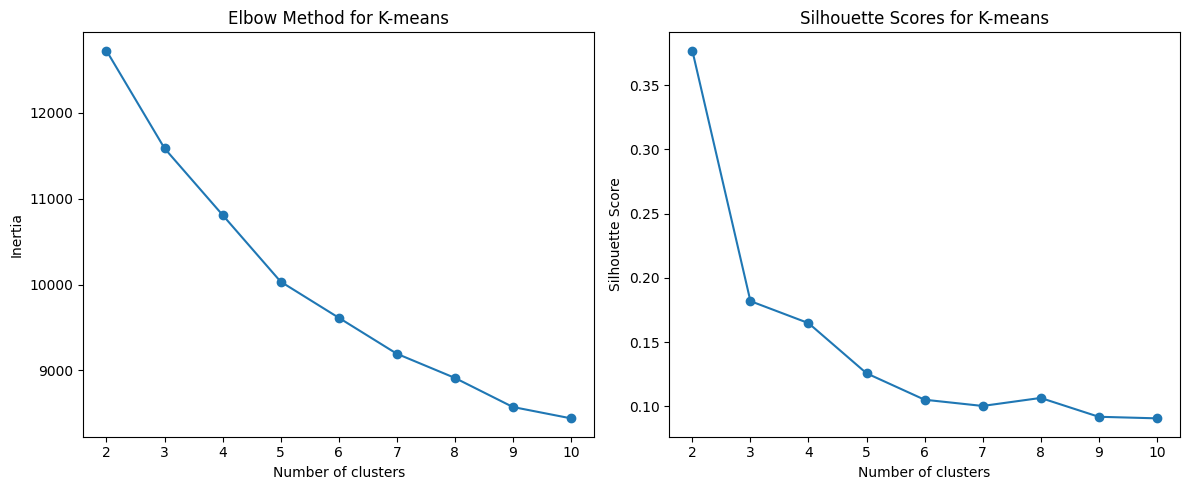

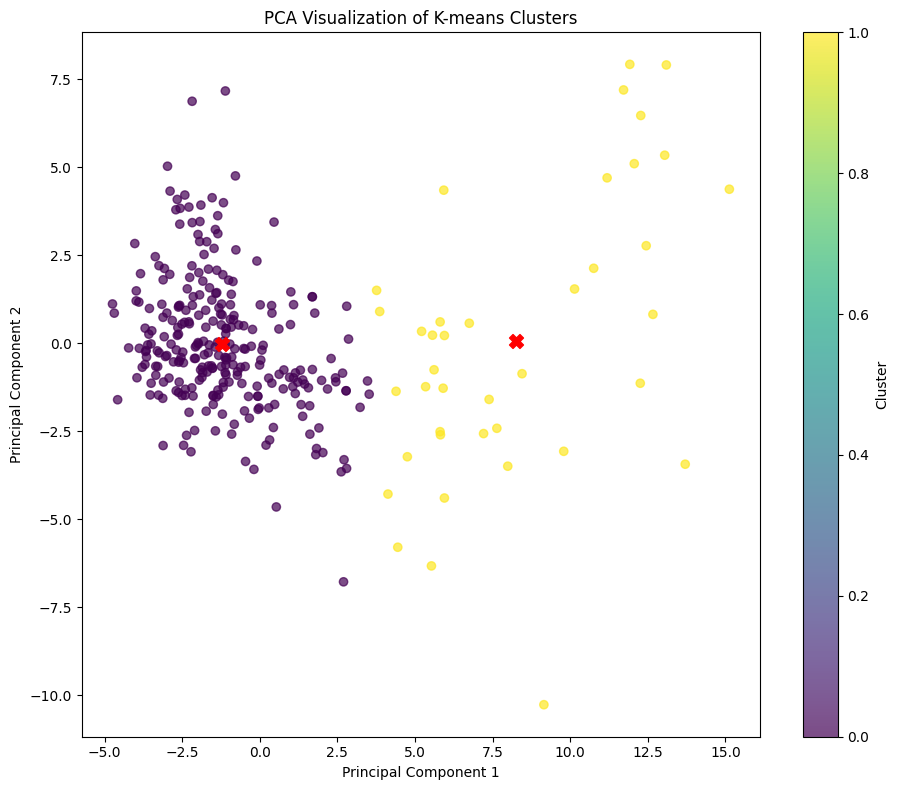

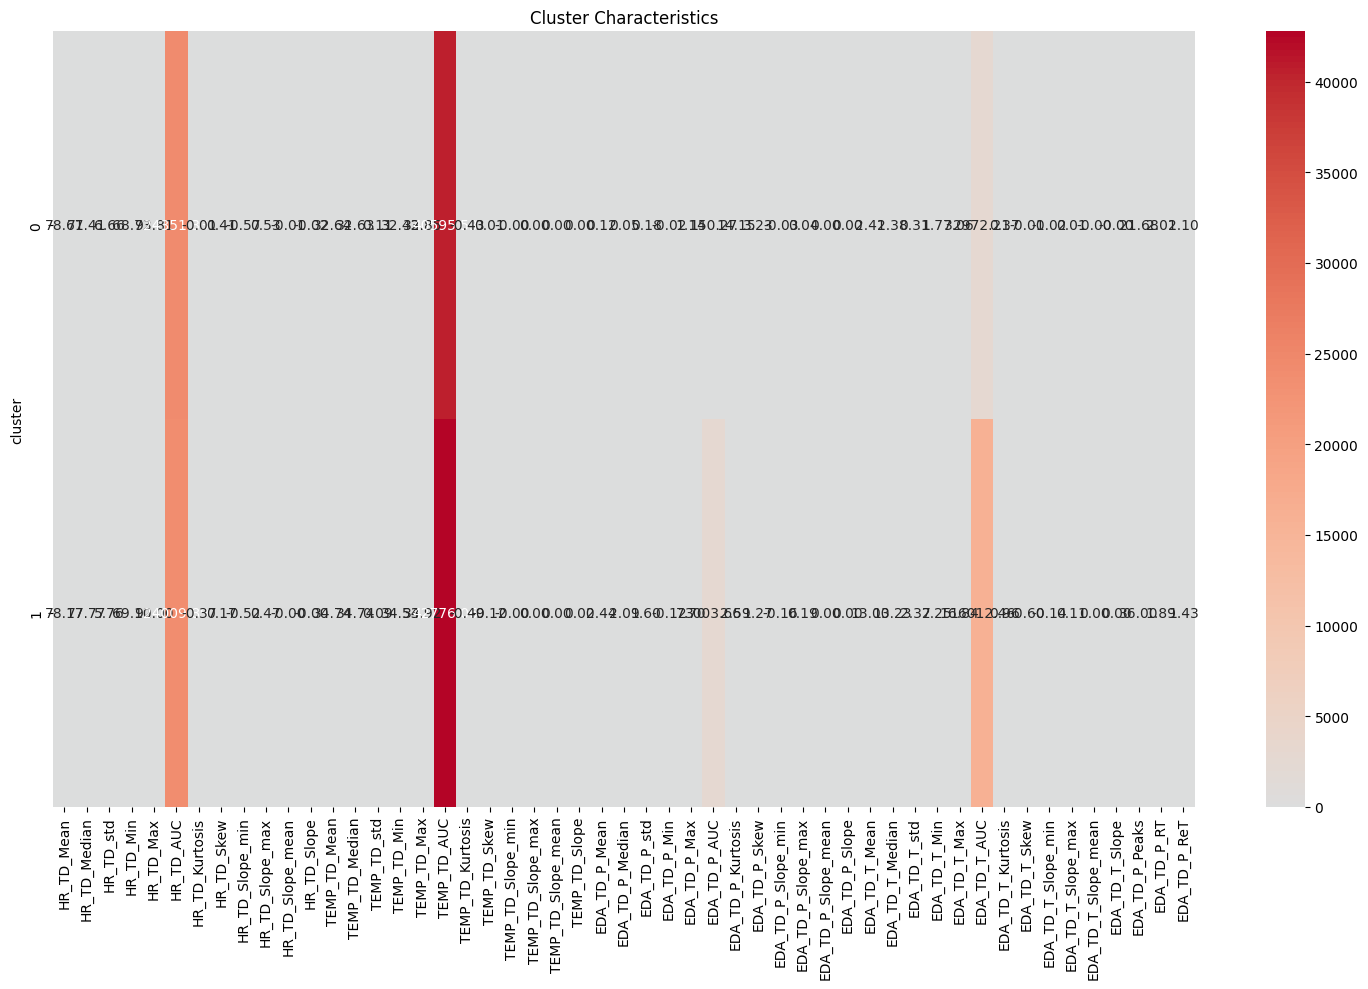

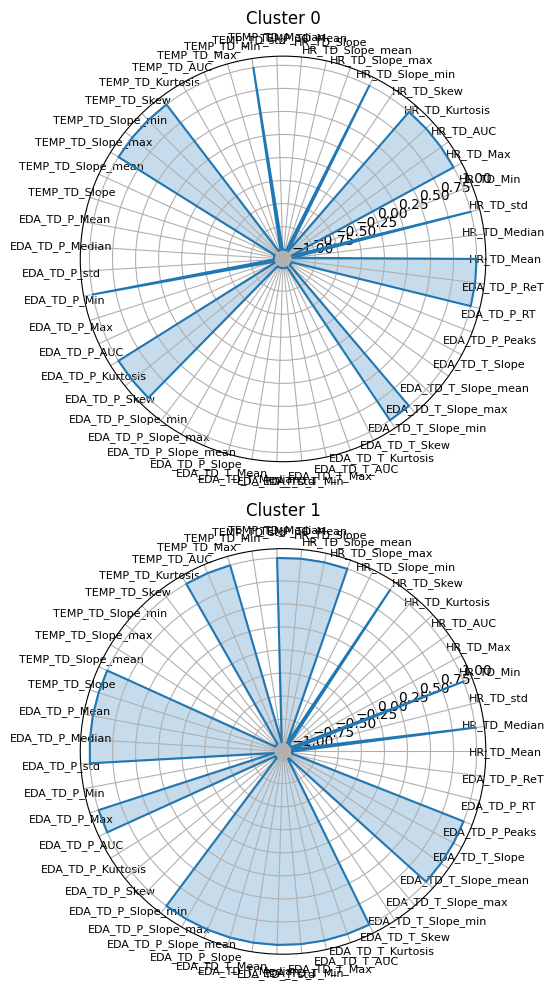

In [14]:
kmeans_labels, kmeans_centers, optimal_k = apply_kmeans_clustering(X_scaled, max_clusters=10)
visualize_clusters_2d(X_scaled, kmeans_labels, centers=kmeans_centers, method_name="K-means")
analyze_clusters(data_pd, kmeans_labels, numeric_columns)

### GMM Clustering

Optimal number of GMM components based on BIC: 2


,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,HR_TD_Slope_max,...,EDA_TD_T_AUC,EDA_TD_T_Kurtosis,EDA_TD_T_Skew,EDA_TD_T_Slope_min,EDA_TD_T_Slope_max,EDA_TD_T_Slope_mean,EDA_TD_T_Slope,EDA_TD_P_Peaks,EDA_TD_P_RT,EDA_TD_P_ReT
cluster,,,,,,,,,,,,,,,,,,,,,
0,78.605357,77.40671,6.661103,68.727426,92.812206,24351.333290,-0.008990,0.405856,-0.574596,0.525416,...,2972.206747,0.366197,-0.005546,-0.015809,0.014538,-0.000266,-0.000230,21.683824,2.014290,2.099741
1,78.173367,77.76675,5.760807,69.124750,89.995750,24009.890625,-0.365227,0.172808,-0.522771,0.471300,...,16012.455934,0.957230,-0.600575,-0.136228,0.107185,0.000166,0.000441,36.000000,1.889899,1.432547


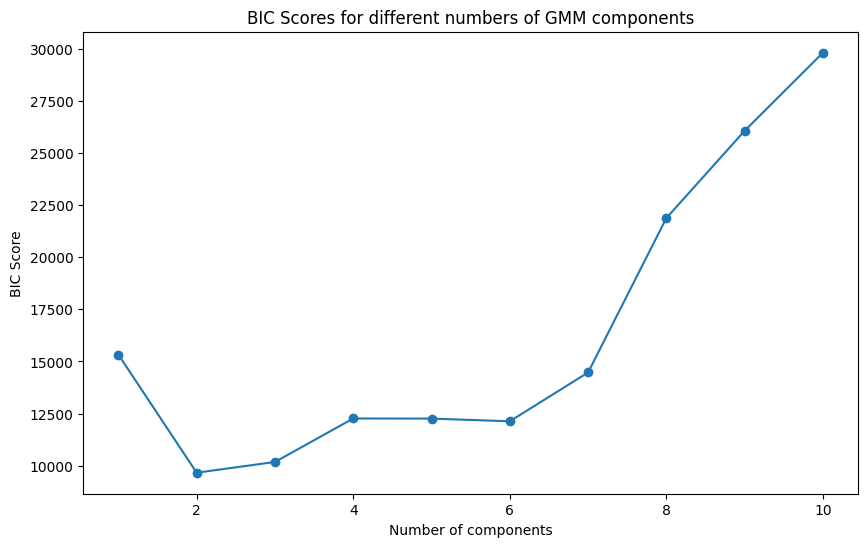

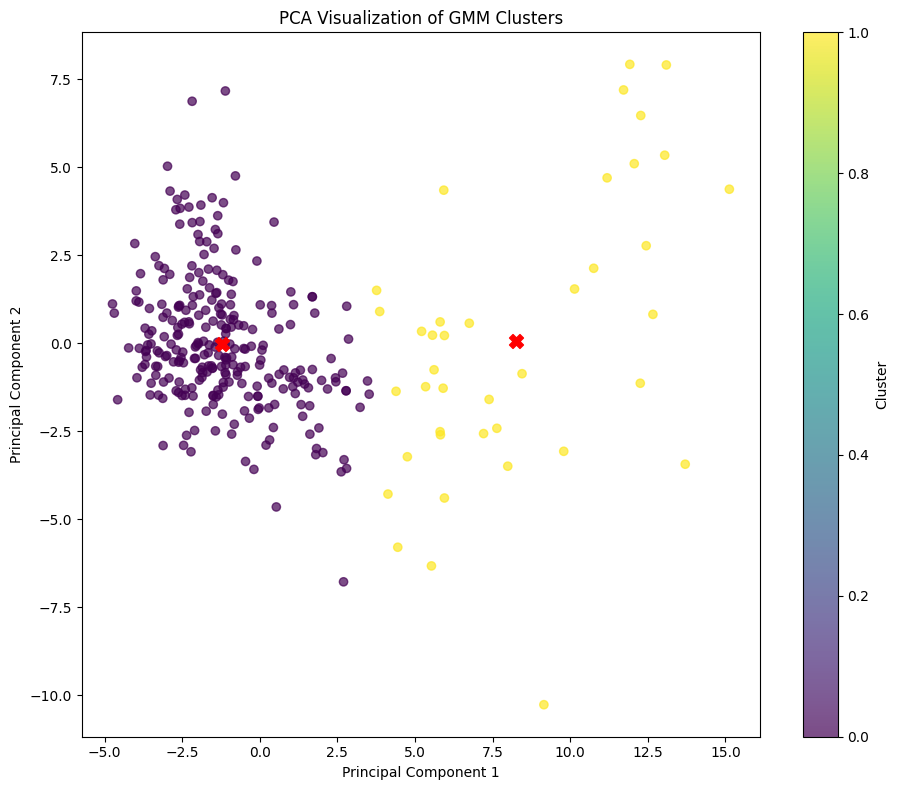

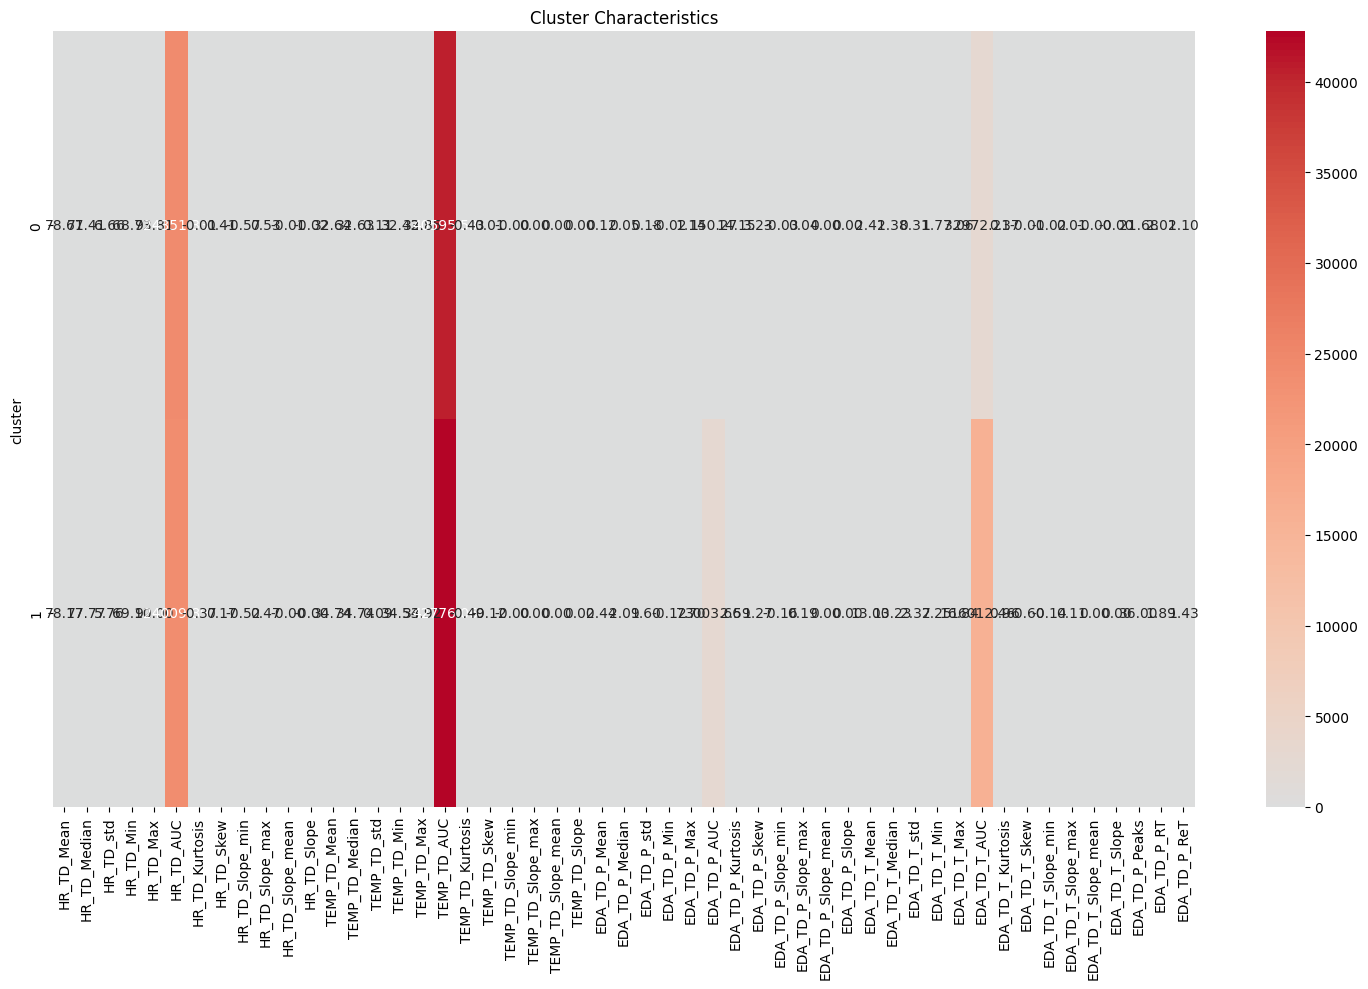

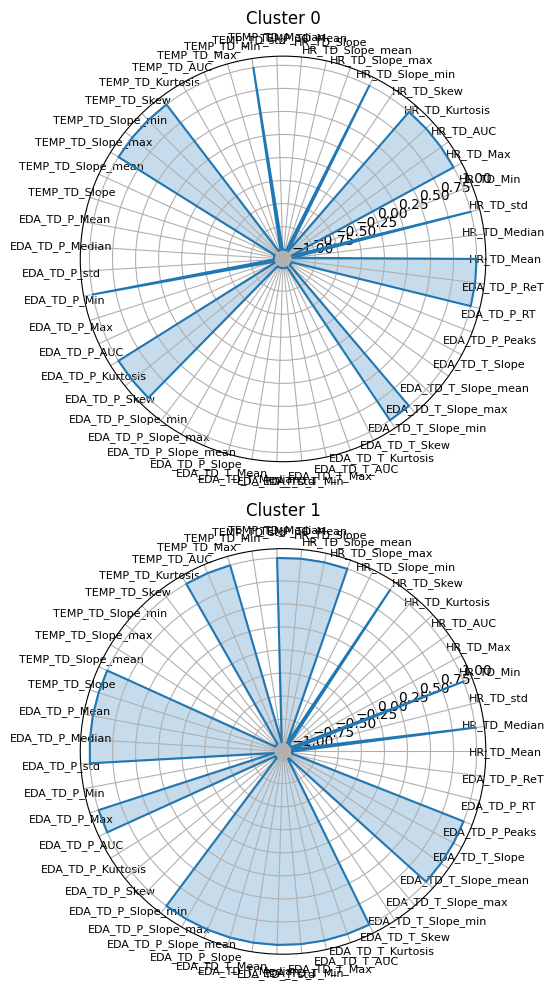

In [15]:
gmm_labels, gmm_centers, optimal_components = apply_gmm_clustering(X_scaled, max_components=10)
visualize_clusters_2d(X_scaled, gmm_labels, centers=gmm_centers, method_name="GMM")
analyze_clusters(data_pd, gmm_labels, numeric_columns)

### DBScan Clustering

Number of clusters: 2
Number of noise points: 211


,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,HR_TD_Slope_max,...,EDA_TD_T_AUC,EDA_TD_T_Kurtosis,EDA_TD_T_Skew,EDA_TD_T_Slope_min,EDA_TD_T_Slope_max,EDA_TD_T_Slope_mean,EDA_TD_T_Slope,EDA_TD_P_Peaks,EDA_TD_P_RT,EDA_TD_P_ReT
cluster,,,,,,,,,,,,,,,,,,,,,
-1,80.180100,78.817204,7.675616,69.051327,96.698104,24896.562275,0.120347,0.452014,-0.649621,0.593196,...,5894.146473,0.866109,-0.207214,-0.043459,0.035940,-0.000272,-0.000178,23.900474,2.028569,2.019839
0,75.119648,74.573041,4.225215,68.136186,83.643814,23093.152835,-0.431060,0.201025,-0.400732,0.366117,...,1981.491554,-0.408142,0.189274,-0.005383,0.006133,-0.000149,-0.000142,22.711340,1.940986,1.988009
1,75.746239,75.320000,3.212879,69.952500,82.000000,22686.953750,-0.158696,0.607728,-0.315000,0.271875,...,3267.221519,-1.316115,-0.042252,-0.014286,0.015831,0.001534,0.001562,23.000000,1.798363,2.332113


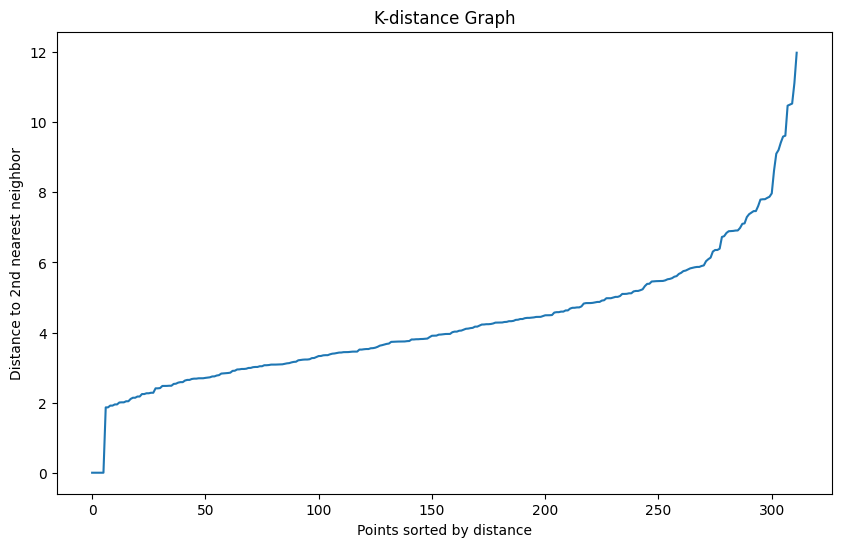

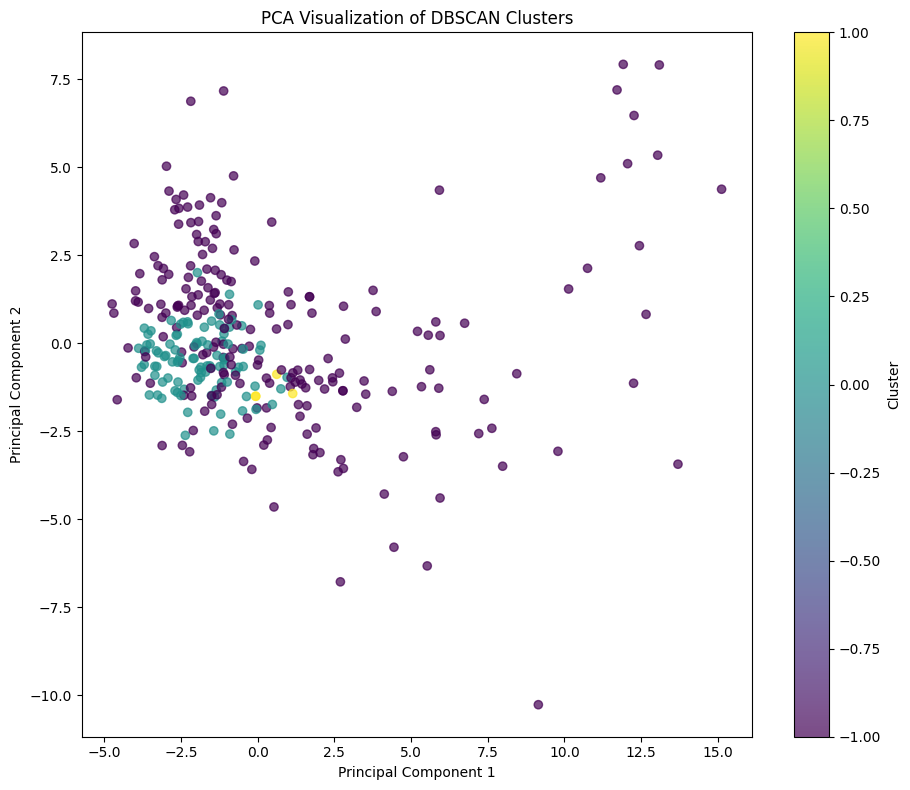

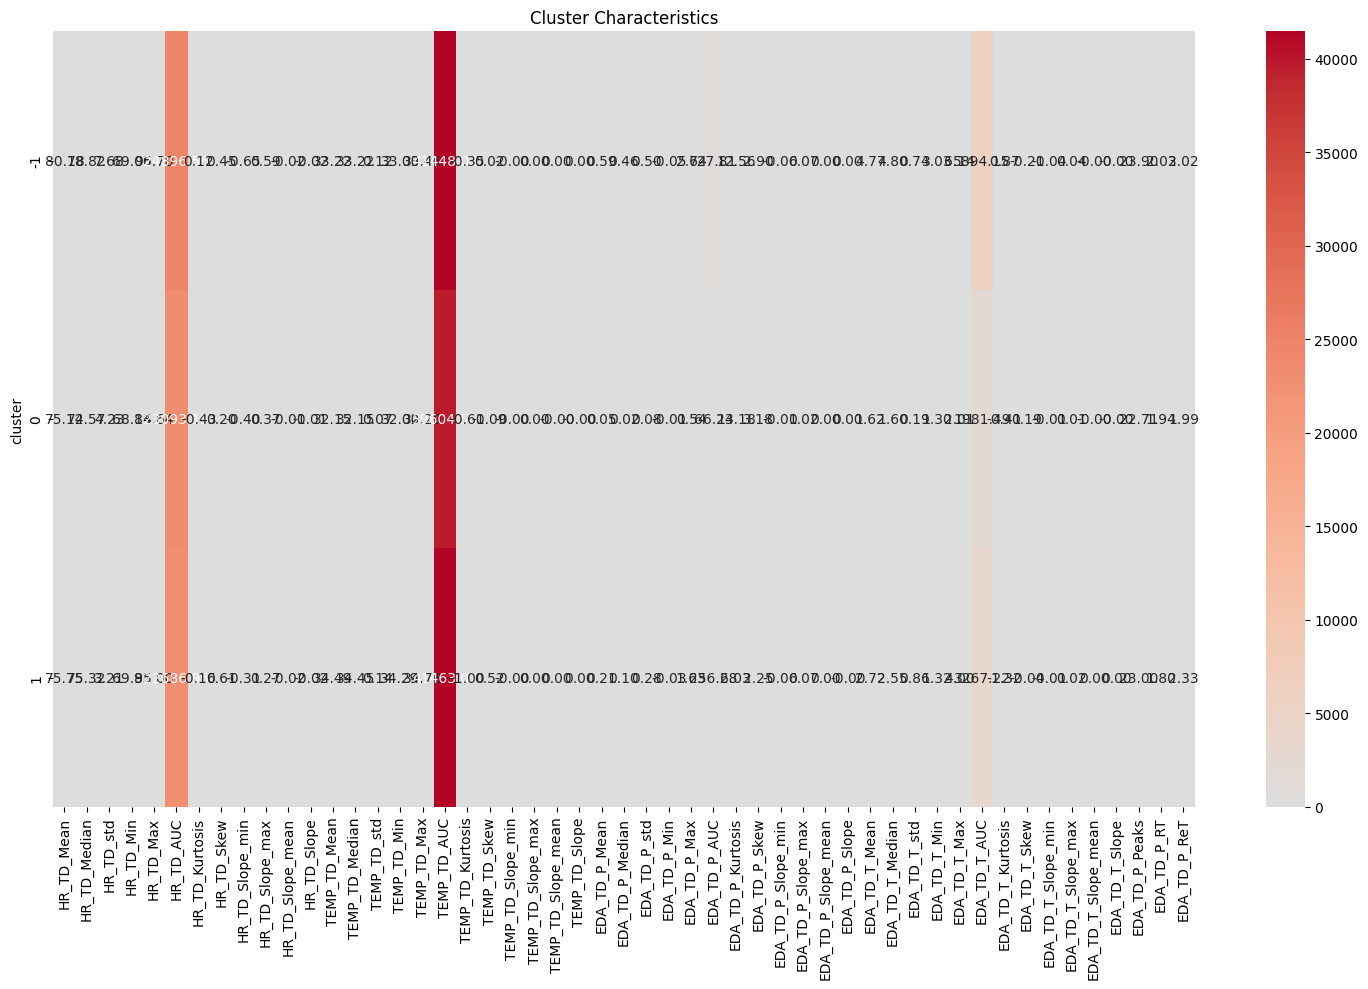

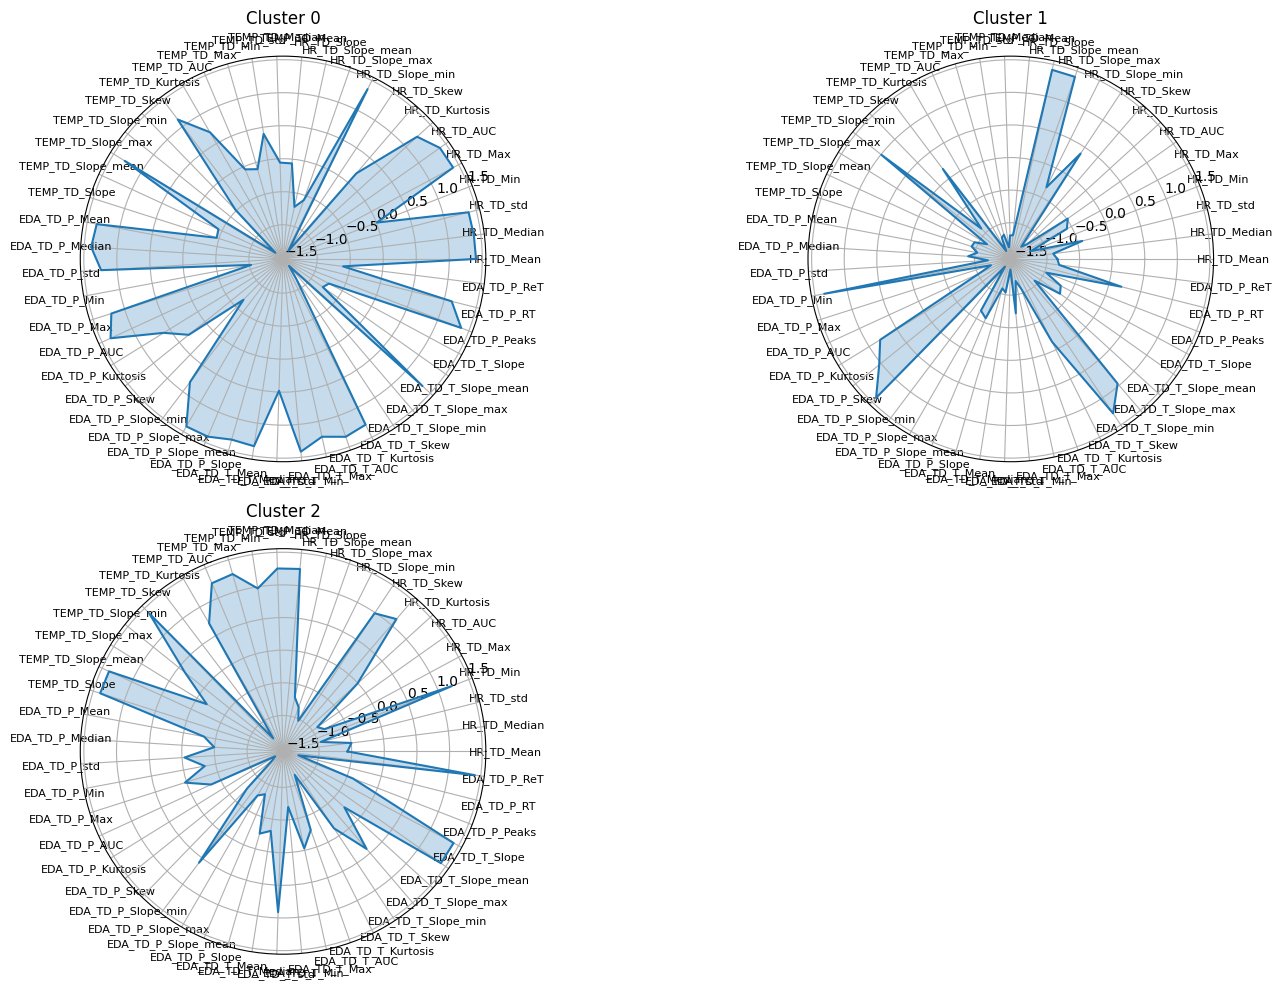

In [16]:
dbscan_labels = apply_dbscan(X_scaled)
visualize_clusters_2d(X_scaled, dbscan_labels, method_name="DBSCAN")
analyze_clusters(data_pd, dbscan_labels, numeric_columns)